In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import linear_regression
import datetime
import random
import tslearn
import scipy
from numpy.polynomial.polynomial import polyfit
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
random.seed(0)

In [78]:
#from print_versions import print_versions
import sys

#print(sys. version)
#print_versions(globals())

# Utilities

In [79]:
def computeSlopes(df):
    slopes = []
    for index, row in df.iterrows():
        y = np.array(row)
        x = np.arange(0, y.size)
        X = np.column_stack([np.ones_like(x), x])
        coef, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
        slope = coef[1]
        slopes.append(slope)
    return slopes

In [80]:
def gradientRegression(X, Y):
    model = LinearRegression().fit(X, Y)
    Y_pred = model.predict(X)
    r2_slope1 = r2_score(Y[:,0], Y_pred[:,0])
    r2_slope2 = r2_score(Y[:,1], Y_pred[:,1])
    r2_slope3 = r2_score(Y[:,2], Y_pred[:,2])
    return model.coef_, model.intercept_, r2_slope1, r2_slope2, r2_slope3 

In [81]:
def decisionTree(ndim, X_train, X_test, y_train, y_test):
    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train.reshape(-1, ndim),y_train)
    y_pred = clf.predict(X_test.reshape(-1, ndim))
    print("Decision Tree Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Decision Tree Precision:", metrics.precision_score(y_test, y_pred, average='macro'))
    print("Decision Tree Recall:", metrics.recall_score(y_test, y_pred, average='macro'))
    print("Decision Tree F1:", metrics.f1_score(y_test, y_pred, average='macro'))

In [82]:
def randomForest(ndim, X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier()
    clf = clf.fit(X_train.reshape(-1, ndim),y_train)
    y_pred = clf.predict(X_test.reshape(-1, ndim))
    print("Random Forest Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Random Forest Precision:", metrics.precision_score(y_test, y_pred, average='macro'))
    print("Random Forest Recall:", metrics.recall_score(y_test, y_pred, average='macro'))
    print("Random Forest F1:", metrics.f1_score(y_test, y_pred, average='macro'))

In [83]:
def randomForest2(ndim, X_train, X_test, y_train, y_test, filename):
    train_loss = []
    val_loss = []
    n_estimators_list = range(1, 51)  # simulate "epochs" via number of trees

    for n in n_estimators_list:
        clf = RandomForestClassifier(n_estimators=n, random_state=42, warm_start=True)
        clf.fit(X_train.reshape(-1, ndim), y_train)
        y_pred_train = clf.predict(X_train.reshape(-1, ndim))
        y_pred_val = clf.predict(X_test.reshape(-1, ndim))

        # 1 - accuracy ≈ "loss"
        train_loss.append(1 - metrics.accuracy_score(y_train, y_pred_train))
        val_loss.append(1 - metrics.accuracy_score(y_test, y_pred_val))

    # Final model metrics
    print("Random Forest Accuracy:", metrics.accuracy_score(y_test, y_pred_val))
    print("Random Forest Precision:", metrics.precision_score(y_test, y_pred_val, average='macro'))
    print("Random Forest Recall:", metrics.recall_score(y_test, y_pred_val, average='macro'))
    print("Random Forest F1:", metrics.f1_score(y_test, y_pred_val, average='macro'))

    # Plot training vs validation loss
    plt.plot(n_estimators_list, train_loss, label='Train Loss', color='skyblue')
    plt.plot(n_estimators_list, val_loss, label='Validation Loss', color='salmon')
    plt.xlabel('Number of Trees (Estimators)')
    plt.ylabel('Loss (1 - Accuracy)')
    plt.title('Random Forest Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

In [84]:
def randomForest3(ndim, X_train, X_test, y_train, y_test, cv=5, scoring='accuracy', filename="null"):
    clf = RandomForestClassifier()
    clf = clf.fit(X_train.reshape(-1, ndim), y_train)
    y_pred = clf.predict(X_test.reshape(-1, ndim))

    print("Random Forest Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Random Forest Precision:", metrics.precision_score(y_test, y_pred, average='macro'))
    print("Random Forest Recall:", metrics.recall_score(y_test, y_pred, average='macro'))
    print("Random Forest F1:", metrics.f1_score(y_test, y_pred, average='macro'))

    # --- added: learning curve (train vs validation accuracy) ---
    Xtr = X_train.reshape(-1, ndim)
    train_sizes, train_scores, val_scores = learning_curve(
        RandomForestClassifier(n_estimators=clf.n_estimators, random_state=42),
        Xtr, y_train,
        cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 8), shuffle=True, random_state=42
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mean, 'o-', label='Train Accuracy')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Random Forest Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

# Bank Reserves

In [85]:
br_poor = pd.read_csv("~/Desktop/TS-Clustering/SimData/bank_reserves_outputs_poor.csv", header=None)
br_middle = pd.read_csv("~/Desktop/TS-Clustering/SimData/bank_reserves_outputs_middle.csv", header=None)
br_rich = pd.read_csv("~/Desktop/TS-Clustering/SimData/bank_reserves_outputs_rich.csv", header=None)
br_inputs = pd.read_csv("~/Desktop/TS-Clustering/SimData/bank_reserves_inputs.csv", header=None)
br_inputs_arr = br_inputs.iloc[:, 0].to_numpy()

In [86]:
slopes_poor = computeSlopes(br_poor)

In [87]:
slopes_middle = computeSlopes(br_middle)

In [88]:
slopes_rich = computeSlopes(br_rich)

In [89]:
X = br_inputs_arr.reshape(-1, 1)          
Y = np.column_stack([slopes_poor, slopes_middle, slopes_rich])
coefs, intercepts, r2_poor, r2_middle, r2_rich = gradientRegression(X, Y)

In [90]:
print(r2_poor)
print(r2_middle)
print(r2_rich)

0.9039877634820104
0.8988972462866229
0.8607613944321865


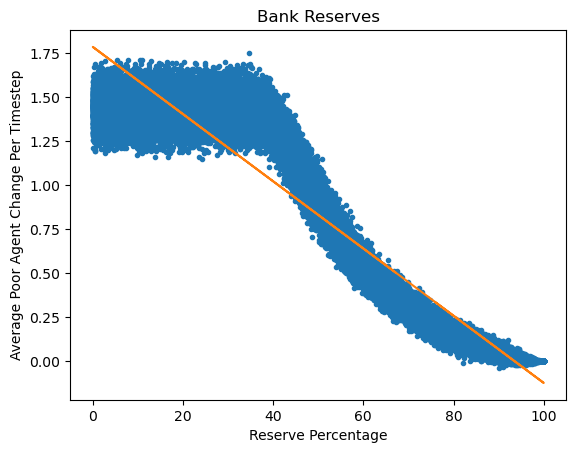

In [91]:
plt.plot(br_inputs_arr, slopes_poor, '.')
plt.plot(br_inputs_arr, intercepts[0] + coefs[0][0] * br_inputs_arr, '-')
plt.xlabel("Reserve Percentage")
plt.ylabel("Average Poor Agent Change Per Timestep")
plt.title("Bank Reserves")
plt.savefig('bank_reserve_slope.png')
plt.show()

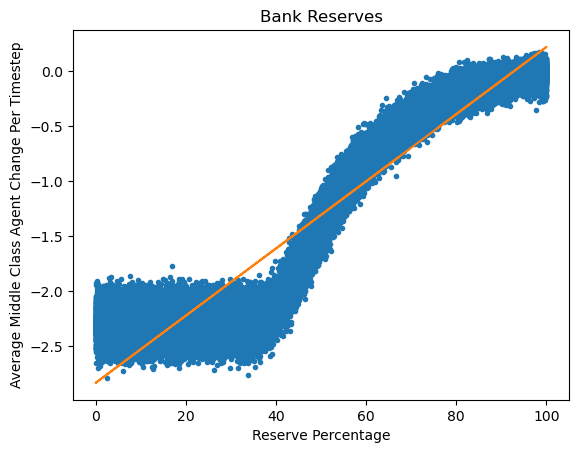

In [92]:
plt.plot(br_inputs_arr, slopes_middle, '.')
plt.plot(br_inputs_arr, intercepts[1] + coefs[1][0] * br_inputs_arr, '-')
plt.xlabel("Reserve Percentage")
plt.ylabel("Average Middle Class Agent Change Per Timestep")
plt.title("Bank Reserves")
plt.savefig('bank_reserve_slope_middle.png')
plt.show()

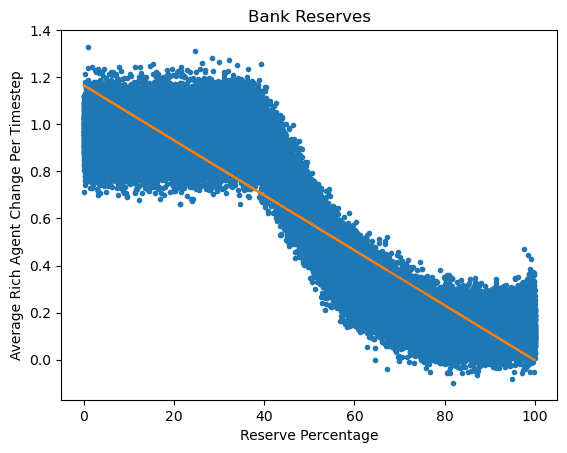

In [93]:
plt.plot(br_inputs_arr, slopes_rich, '.')
plt.plot(br_inputs_arr, intercepts[2] + coefs[2][0] * br_inputs_arr, '-')
plt.xlabel("Reserve Percentage")
plt.ylabel("Average Rich Agent Change Per Timestep")
plt.title("Bank Reserves")
plt.savefig('bank_reserve_slope_rich.png')
plt.show()

In [94]:
gradients = np.column_stack([
    slopes_poor,
    slopes_middle,
    slopes_rich
])
g_norm = np.linalg.norm(gradients, axis=1)

In [95]:
model = LinearRegression().fit(br_inputs_arr.reshape(-1, 1), g_norm)

In [96]:
Y_pred = model.predict(br_inputs_arr.reshape(-1, 1))
r2 = r2_score(g_norm, Y_pred)

In [97]:
r2

0.8964432967811576

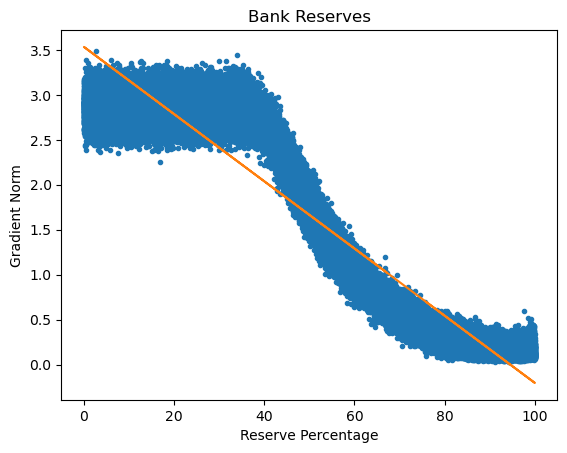

In [98]:
plt.plot(br_inputs_arr, g_norm, '.')
plt.plot(br_inputs_arr, model.intercept_ + model.coef_ * br_inputs_arr, '-')
plt.xlabel("Reserve Percentage")
plt.ylabel("Gradient Norm")
plt.title("Bank Reserves")
plt.savefig('bank_reserve_gradient_norm.png')
plt.show()

In [108]:
g = np.asarray(g_norm).reshape(-1, 1)  # ensure 2D for k-means

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_ids = kmeans.fit_predict(g)          # shape (N,)
centers = kmeans.cluster_centers_.flatten()  # shape (3,)

In [109]:
order = np.argsort(centers)  # smallest → largest

# build a map: raw_cluster_id → label
cluster_to_label = {}

cluster_to_label[order[0]] = "low"
cluster_to_label[order[1]] = "low medium"
cluster_to_label[order[2]] = "high medium"
cluster_to_label[order[3]] = "high"

In [110]:
inputs_class = [cluster_to_label[c] for c in cluster_ids]

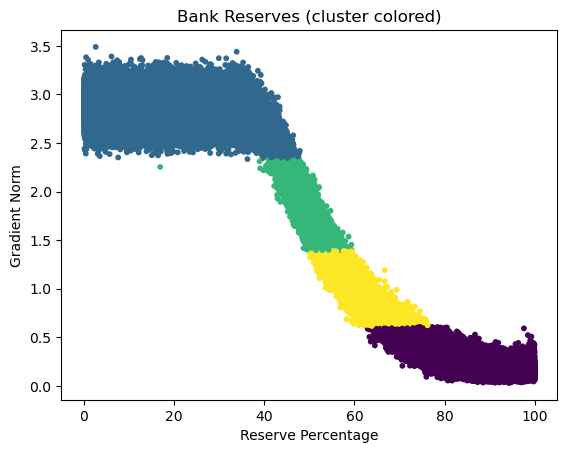

In [111]:
plt.scatter(
    br_inputs_arr,
    g_norm,
    c=cluster_ids,       # or inputs_class
    cmap='viridis',
    s=10
)

plt.xlabel("Reserve Percentage")
plt.ylabel("Gradient Norm")
plt.title("Bank Reserves (cluster colored)")
plt.savefig('bank_reserve_gradient_norm_clusters.png')
plt.show()

In [112]:
X_train, X_test, y_train, y_test = train_test_split(br_inputs_arr, inputs_class, test_size=0.2, random_state=1) 

In [113]:
randomForest(1, X_train, X_test, y_train, y_test)

Random Forest Accuracy: 0.93515
Random Forest Precision: 0.8984603145010144
Random Forest Recall: 0.9000886548243705
Random Forest F1: 0.8992580424455321


Random Forest Accuracy: 0.9353
Random Forest Precision: 0.898933522625007
Random Forest Recall: 0.9001974875700768
Random Forest F1: 0.8995458020699904


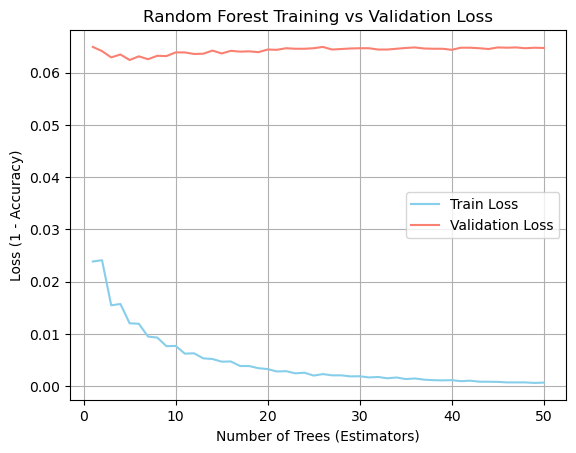

In [114]:
randomForest2(1, X_train, X_test, y_train, y_test, "br_rf_training_n_trees.png")
#plt.savefig("br_rf_training_n_trees.png", format="png")

Random Forest Accuracy: 0.9351
Random Forest Precision: 0.898407980278115
Random Forest Recall: 0.9000029797044253
Random Forest F1: 0.8991887635547373


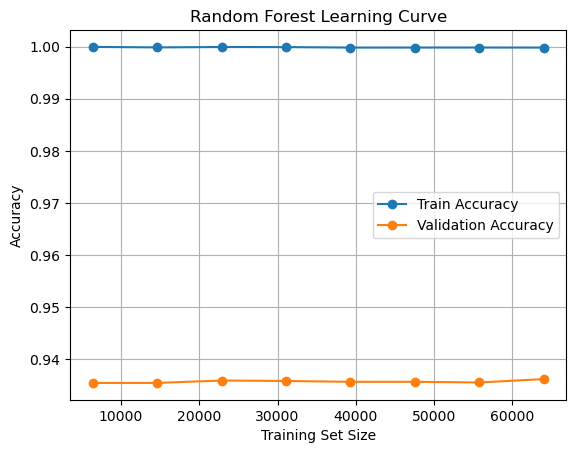

In [115]:
from sklearn.model_selection import learning_curve
randomForest3(1, X_train, X_test, y_train, y_test, 5, "accuracy", "br_rf_training_train_size.png")
#plt.savefig("br_rf_training_train_size.png", format="png")

# Epstein Civil Violence

In [116]:
ecv_active = pd.read_csv("~/Desktop/TS-Clustering/SimData/epsteinCV_outputs_active.csv", header=None)
ecv_jailed = pd.read_csv("~/Desktop/TS-Clustering/SimData/epsteinCV_outputs_jailed.csv", header=None)
ecv_quiet = pd.read_csv("~/Desktop/TS-Clustering/SimData/epsteinCV_outputs_quiet.csv", header=None)
ecv_inputs = pd.read_csv("~/Desktop/TS-Clustering/SimData/epsteinCV_inputs.csv", header=None, sep=" ")
ecv_inputs_arr = ecv_inputs.to_numpy()

In [117]:
slopes_active = computeSlopes(ecv_active)

In [118]:
slopes_jailed = computeSlopes(ecv_jailed)

In [119]:
slopes_quiet = computeSlopes(ecv_quiet)

In [120]:
X = ecv_inputs_arr 
Y = np.column_stack([slopes_active, slopes_jailed, slopes_quiet])      
coefs, intercepts, r2_poor, r2_middle, r2_rich = gradientRegression(X, Y)

In [121]:
print(r2_poor)
print(r2_middle)
print(r2_rich)

0.25459108626016624
0.08802869686485526
0.11757516291427206


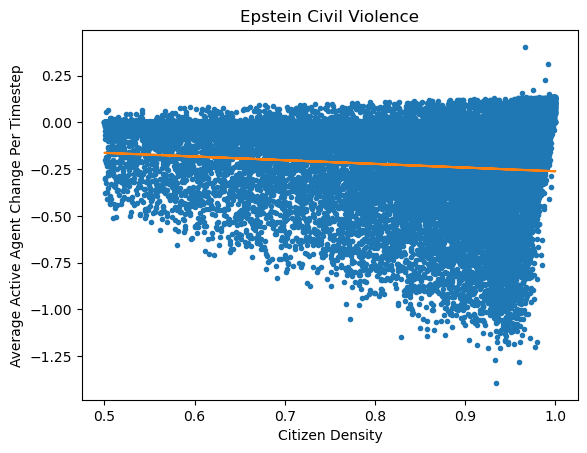

In [122]:
k = 0

x1_mean = np.mean(ecv_inputs_arr[:,1])
x2_mean = np.mean(ecv_inputs_arr[:,2])

y_hat = (
    intercepts[k]
    + coefs[0, k] * ecv_inputs_arr[:, 0]   
    + coefs[1, k] * x1_mean                
    + coefs[2, k] * x2_mean                
)

plt.plot(ecv_inputs_arr[:,0], slopes_active, '.')
plt.plot(ecv_inputs_arr[:,0], y_hat, '-')
plt.xlabel("Citizen Density")
plt.ylabel("Average Active Agent Change Per Timestep")
plt.title("Epstein Civil Violence")
plt.savefig('ecv_citdens_slope.png')
plt.show()

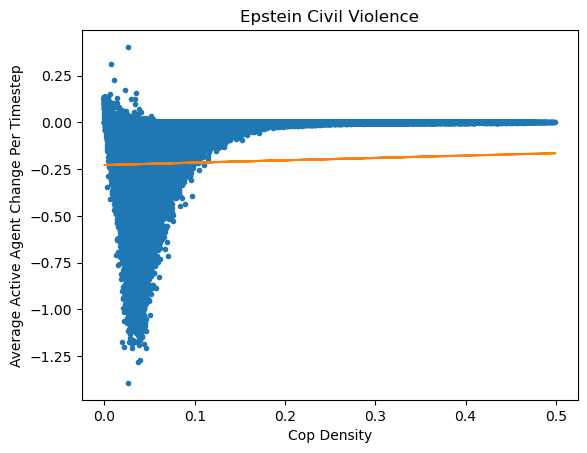

In [123]:
k = 0

x0_mean = np.mean(ecv_inputs_arr[:,0])
x2_mean = np.mean(ecv_inputs_arr[:,2])
y_hat = (
    intercepts[k]
    + coefs[0, k] * x0_mean        
    + coefs[1, k] * ecv_inputs_arr[:,1]  
    + coefs[2, k] * x2_mean        
)

plt.plot(ecv_inputs_arr[:,1], slopes_active, '.')
plt.plot(ecv_inputs_arr[:,1], y_hat, '-')
plt.xlabel("Cop Density")
plt.ylabel("Average Active Agent Change Per Timestep")
plt.title("Epstein Civil Violence")
plt.savefig('ecv_copdens_slope.png')
plt.show()

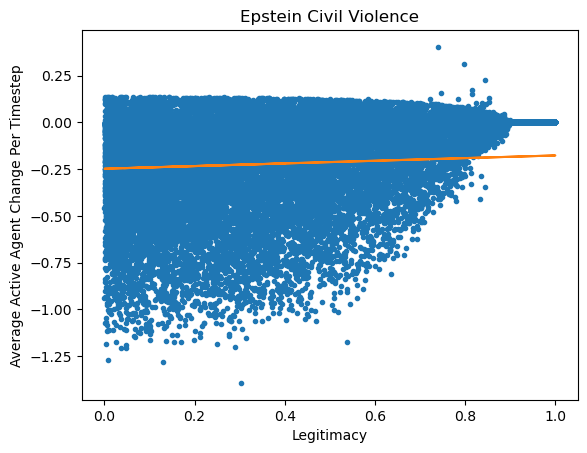

In [124]:
k = 0

x0_mean = np.mean(ecv_inputs_arr[:,0])
x1_mean = np.mean(ecv_inputs_arr[:,1])

y_hat = (
    intercepts[k]
    + coefs[0, k] * x0_mean               
    + coefs[1, k] * x1_mean               
    + coefs[2, k] * ecv_inputs_arr[:,2]   
)

plt.plot(ecv_inputs_arr[:,2], slopes_active, '.')
plt.plot(ecv_inputs_arr[:,2], y_hat, '-')
plt.xlabel("Legitimacy")
plt.ylabel("Average Active Agent Change Per Timestep")
plt.title("Epstein Civil Violence")
plt.savefig('ecv_legit_slope.png')
plt.show()

In [125]:
gradients = np.column_stack([
    slopes_active,
    slopes_jailed,
    slopes_quiet
])
g_norm = np.linalg.norm(gradients, axis=1)

In [126]:
model = LinearRegression().fit(ecv_inputs_arr, g_norm)

In [127]:
Y_pred = model.predict(ecv_inputs_arr)
r2 = r2_score(g_norm, Y_pred)

In [128]:
r2

0.40300427210799894

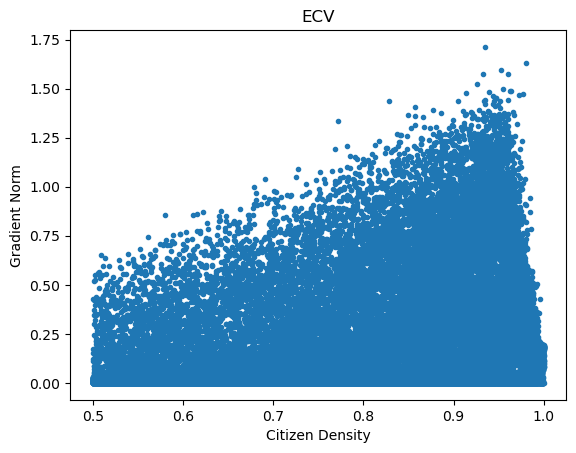

In [129]:
plt.plot(ecv_inputs_arr[:,0], g_norm, '.')
plt.xlabel("Citizen Density")
plt.ylabel("Gradient Norm")
plt.title("ECV")
plt.savefig('ecv_gradient_norm0.png')
plt.show()

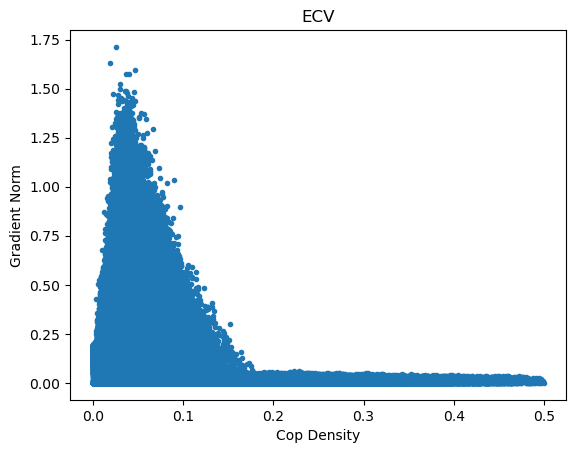

In [130]:
plt.plot(ecv_inputs_arr[:,1], g_norm, '.')
plt.xlabel("Cop Density")
plt.ylabel("Gradient Norm")
plt.title("ECV")
plt.savefig('ecv_gradient_norm1.png')
plt.show()

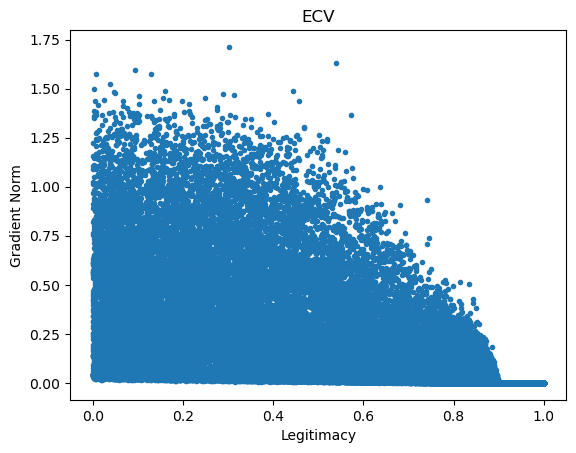

In [131]:
plt.plot(ecv_inputs_arr[:,2], g_norm, '.')
plt.xlabel("Legitimacy")
plt.ylabel("Gradient Norm")
plt.title("ECV")
plt.savefig('ecv_gradient_norm2.png')
plt.show()

In [132]:
g = np.asarray(g_norm).reshape(-1, 1)  # ensure 2D for k-means

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_ids = kmeans.fit_predict(g)          # shape (N,)
centers = kmeans.cluster_centers_.flatten()  # shape (3,)

In [133]:
order = np.argsort(centers)  # smallest → largest

# build a map: raw_cluster_id → label
cluster_to_label = {}

cluster_to_label[order[0]] = "low"
cluster_to_label[order[1]] = "low medium"
cluster_to_label[order[2]] = "high medium"
cluster_to_label[order[3]] = "high"

In [134]:
inputs_class = [cluster_to_label[c] for c in cluster_ids]

In [135]:
X_train, X_test, y_train, y_test = train_test_split(ecv_inputs_arr, inputs_class, test_size=0.2, random_state=1) 

In [136]:
randomForest(3, X_train, X_test, y_train, y_test)

Random Forest Accuracy: 0.893378338131639
Random Forest Precision: 0.7900493244667588
Random Forest Recall: 0.7905619901272214
Random Forest F1: 0.7902238918090418


Random Forest Accuracy: 0.8913928323240345
Random Forest Precision: 0.7841461051285189
Random Forest Recall: 0.7851309516213452
Random Forest F1: 0.7845686310188282


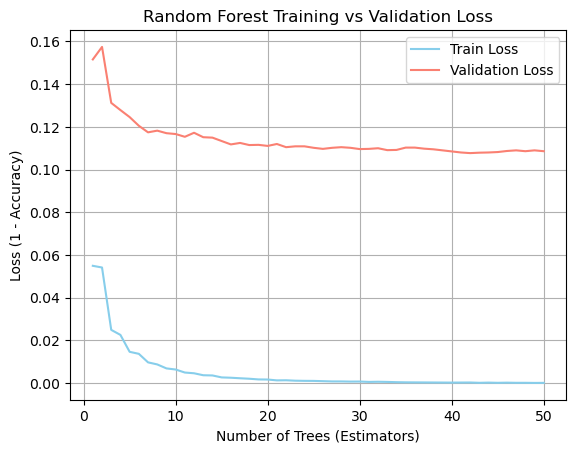

In [137]:
randomForest2(3, X_train, X_test, y_train, y_test, "ecv_rf_training_n_trees.png")
#plt.savefig("ecv_rf_training_n_trees.png", format="png")

Random Forest Accuracy: 0.89377543929316
Random Forest Precision: 0.791146835805514
Random Forest Recall: 0.7900692193921062
Random Forest F1: 0.7905580450630663


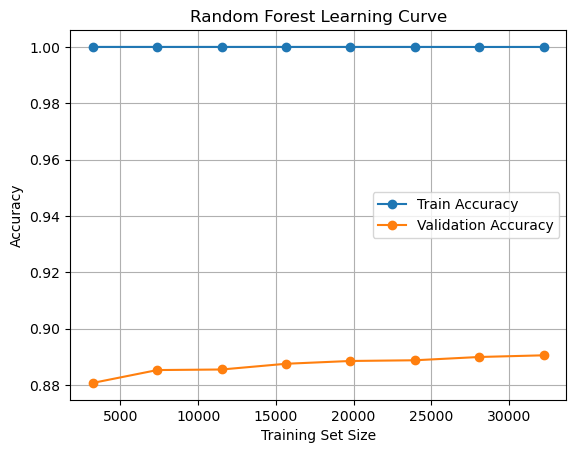

In [138]:
randomForest3(3, X_train, X_test, y_train, y_test, 5, "accuracy", "ecv_rf_training_train_size.png")
#plt.savefig("ecv_rf_training_train_size.png", format="png")

# Forest Fire

In [139]:
def import_ff_data(filename):
    expected_columns=155
    data = []
    with open(filename, 'r') as file:
        for line in file:
            row = line.strip().split(',')
            if len(row) < expected_columns:
                row += [np.nan] * (expected_columns - len(row))
            data.append(row)
    df = pd.DataFrame(data)
    def fill_last_valid(row):
        for i in range(1, len(row)):
            if pd.isna(row[i]):
                row[i] = row[i - 1]  
        return row
    df_filled = df.apply(fill_last_valid, axis=1)
    return df_filled

In [140]:
ff_onfire = import_ff_data("C:/Users/met48/Desktop/TS-Clustering/SimData/forest_fire_outputs_onfire.csv")
ff_fine = import_ff_data("C:/Users/met48/Desktop/TS-Clustering/SimData/forest_fire_outputs_fine.csv")
ff_burned = import_ff_data("C:/Users/met48/Desktop/TS-Clustering/SimData/forest_fire_outputs_burned.csv")

In [141]:
ff_inputs = pd.read_csv("~/Desktop/TS-Clustering/SimData/forest_fire_inputs.csv", header=None, sep=" ")
ff_inputs_arr = ff_inputs.iloc[:, 0].to_numpy()

In [142]:
slopes_burned = computeSlopes(ff_burned.astype('float'))
slopes_onfire = computeSlopes(ff_onfire.astype('float'))
slopes_fine = computeSlopes(ff_fine.astype('float'))

In [143]:
X = ff_inputs_arr.reshape(-1, 1)          
Y = np.column_stack([slopes_burned, slopes_onfire, slopes_fine])
coefs, intercepts, r2_burned, r2_onfire, r2_fine = gradientRegression(X, Y)

In [144]:
print(r2_burned)
print(r2_onfire)
print(r2_fine)

0.7656122978671092
0.9442563251377337
0.7538110850330026


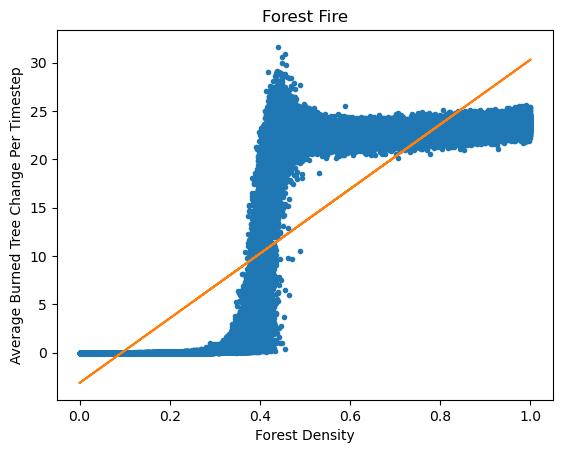

In [145]:
plt.plot(ff_inputs_arr, slopes_burned, '.')
plt.plot(ff_inputs_arr, intercepts[0] + coefs[0][0] * ff_inputs_arr, '-')
plt.xlabel("Forest Density")
plt.ylabel("Average Burned Tree Change Per Timestep")
plt.title("Forest Fire")
plt.savefig('ff_density_slope_burned.png')
plt.show()

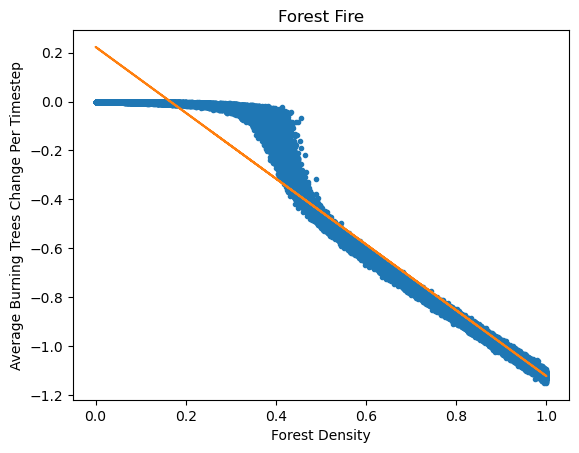

In [146]:
plt.plot(ff_inputs_arr, slopes_onfire, '.')
plt.plot(ff_inputs_arr, intercepts[1] + coefs[1][0] * ff_inputs_arr, '-')
plt.xlabel("Forest Density")
plt.ylabel("Average Burning Trees Change Per Timestep")
plt.title("Forest Fire")
plt.savefig('ff_density_slope_onfire.png')
plt.show()

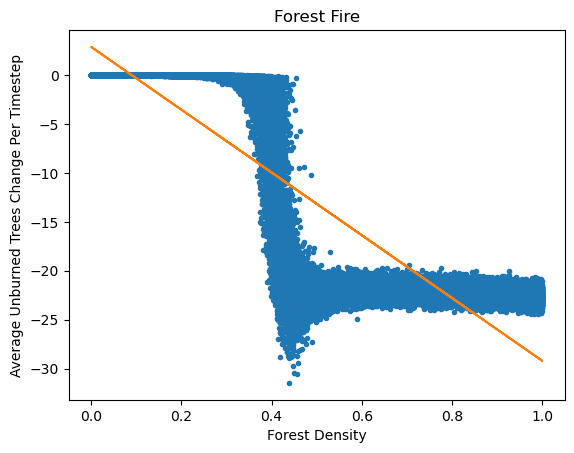

In [147]:
plt.plot(ff_inputs_arr, slopes_fine, '.')
plt.plot(ff_inputs_arr, intercepts[2] + coefs[2][0] * ff_inputs_arr, '-')
plt.xlabel("Forest Density")
plt.ylabel("Average Unburned Trees Change Per Timestep")
plt.title("Forest Fire")
plt.savefig('ff_density_slope_unburned.png')
plt.show()

In [148]:
gradients = np.column_stack([
    slopes_burned,
    slopes_onfire,
    slopes_fine
])
g_norm = np.linalg.norm(gradients, axis=1)

In [149]:
model = LinearRegression().fit(ff_inputs_arr.reshape(-1, 1), g_norm)

In [150]:
Y_pred = model.predict(ff_inputs_arr.reshape(-1, 1))
r2 = r2_score(g_norm, Y_pred)

In [151]:
r2

0.760136313375984

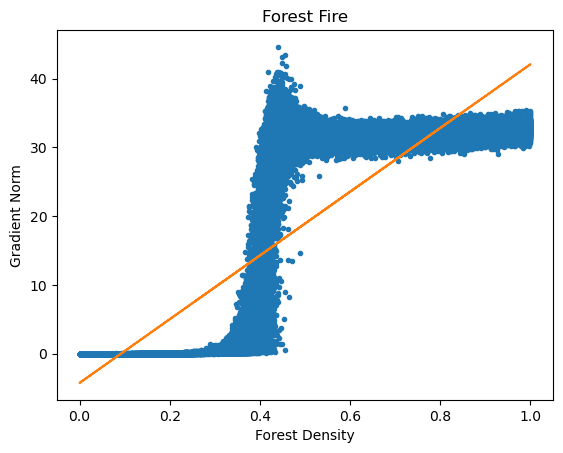

In [152]:
plt.plot(ff_inputs_arr, g_norm, '.')
plt.plot(ff_inputs_arr, model.intercept_ + model.coef_ * ff_inputs_arr, '-')
plt.xlabel("Forest Density")
plt.ylabel("Gradient Norm")
plt.title("Forest Fire")
plt.savefig('ff_gradient_norm.png')
plt.show()

In [155]:
g = np.asarray(g_norm).reshape(-1, 1)  # ensure 2D for k-means

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_ids = kmeans.fit_predict(g)          # shape (N,)
centers = kmeans.cluster_centers_.flatten()  # shape (3,)

In [156]:
order = np.argsort(centers)  # smallest → largest

# build a map: raw_cluster_id → label
cluster_to_label = {}

cluster_to_label[order[0]] = "low"
cluster_to_label[order[1]] = "low medium"
cluster_to_label[order[2]] = "high medium"
cluster_to_label[order[3]] = "high"

In [157]:
inputs_class = [cluster_to_label[c] for c in cluster_ids]

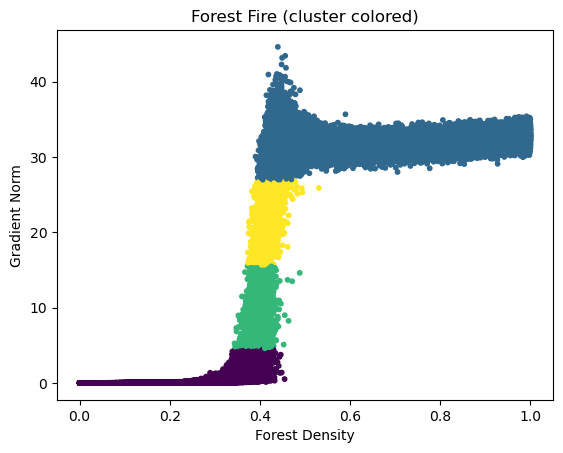

In [159]:
plt.scatter(
    ff_inputs_arr,
    g_norm,
    c=cluster_ids,       # or inputs_class
    cmap='viridis',
    s=10
)

plt.xlabel("Forest Density")
plt.ylabel("Gradient Norm")
plt.title("Forest Fire (cluster colored)")
plt.savefig('ff_gradient_norm_clusters.png')
plt.show()

In [160]:
X_train, X_test, y_train, y_test = train_test_split(ff_inputs_arr, inputs_class, test_size=0.2, random_state=1) 

In [161]:
randomForest(1, X_train, X_test, y_train, y_test)

Random Forest Accuracy: 0.9582
Random Forest Precision: 0.627665825993134
Random Forest Recall: 0.621712925252075
Random Forest F1: 0.6244041440377905


Random Forest Accuracy: 0.95855
Random Forest Precision: 0.6296725338711968
Random Forest Recall: 0.6226127920169652
Random Forest F1: 0.625830109870782


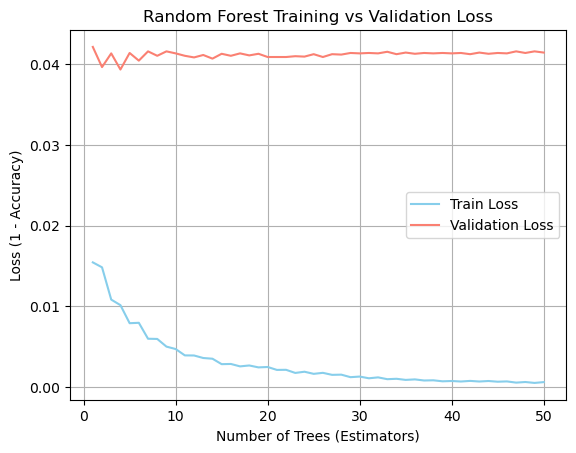

In [162]:
randomForest2(1, X_train, X_test, y_train, y_test, "ff_rf_training_n_trees.png")
#plt.savefig("ff_rf_training_n_trees.png", format="png")

Random Forest Accuracy: 0.95825
Random Forest Precision: 0.6278819265370874
Random Forest Recall: 0.6217348185877436
Random Forest F1: 0.6245257081547806


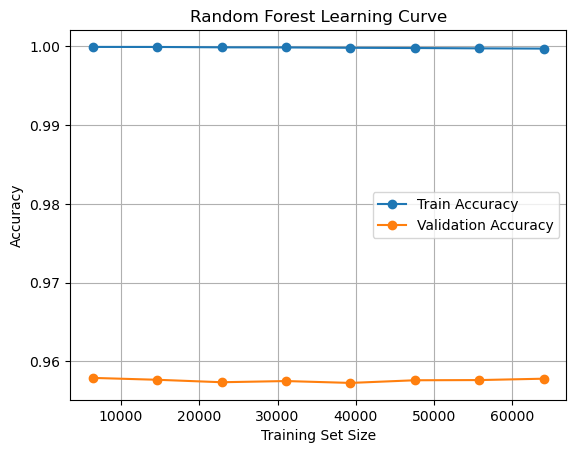

In [163]:
randomForest3(1, X_train, X_test, y_train, y_test, 5, "accuracy",         "ff_rf_training_train_size.png")
#plt.savefig("ff_rf_training_train_size.png", format="png")